In [1]:
import os
import sys
import math
import torch
import keras
import torchvision
import numpy as np
import pandas as pd
from torch import nn
import torch.nn as nn
sys.path.append("..")
import torch.optim as optim
from torch.nn import Parameter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from __future__ import print_function
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as transforms
from torchvision.ops import stochastic_depth
from torch.utils.data import SubsetRandomSampler
from torch.distributions.bernoulli import Bernoulli
from torch.utils.data.sampler import SubsetRandomSampler


import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, initializers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, RepeatVector, TimeDistributed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Load Dataset

**def extract_classes():**
The function initializes a boolean mask (idx) with False values. It then iterates over the given class labels and updates the mask to True where the dataset's target matches the class. Finally, it uses this mask to extract the relevant data and targets.

**def getDataset():**
This function defines transformations such as resizing, random horizontal flipping, and conversion to a tensor. It then loads the CIFAR-10 dataset using torchvision, downloading it if necessary. CIFAR-10 has 10 classes and RGB images, which means the number of input channels is 3.

**def getDataloader():** This function first determines the total number of training samples and shuffles the indices. It then splits the indices into training and validation sets based on valid_size. Using SubsetRandomSampler, it creates samplers for the training and validation datasets.

In [2]:
def extract_classes(dataset, classes):
    """
    Extracts data samples from a dataset that belong to specific classes.

    Parameters:
    - dataset (torchvision dataset): A dataset object that contains `data` (features) and `targets` (labels).
    - classes (list of int): A list of class labels to filter from the dataset.

    Returns:
    - data (torch.Tensor): A tensor containing only the samples that match the specified classes.
    - targets (torch.Tensor): A tensor containing the corresponding labels for the filtered samples.
    """
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in classes:
        idx = idx | (dataset.targets==target)

    data, targets = dataset.data[idx], dataset.targets[idx]
    return data, targets


# Convert the dataset to numpy arrays suitable for Keras training
def convert_to_numpy(loader):
    data_list = []
    target_list = []

    for images, targets in loader:
        # Convert from (C, H, W) to (H, W, C)
        images = images.permute(0, 2, 3, 1).numpy()
        data_list.append(images)
        target_list.append(targets.numpy())

    data = np.concatenate(data_list, axis=0)
    targets = np.concatenate(target_list, axis=0)

    # One-hot encoding the labels for Keras
    targets = to_categorical(targets, num_classes=10)

    return data, targets

def getDataset(dataset):
    """
    Loads the CIFAR10 dataset and applies necessary transformations.

    Parameters:
    - dataset (str): A string specifying the dataset name.

    Returns:
    - trainset: The training dataset with applied transformations.
    - testset: The testing dataset with applied transformations.
    - inputs (int): The number of input channels.
    - num_classes (int): The number of classes in the dataset. For the CIFAR-10 dataset 10 classes.
    """
    transform_cifar = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ])

    if(dataset == 'CIFAR10'):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
        num_classes = 10
        inputs=3  #Input Channel as this is RGB Image

    return trainset, testset, inputs, num_classes


def getDataloader(trainset, testset, valid_size, batch_size, num_workers):
    """
    Creates data loaders for training, validation, and testing.

    Parameters:
    - trainset: The training dataset.
    - testset: The testing dataset.
    - valid_size (float): The proportion of training data to use for validation.
    - batch_size (int): The batch size for the data loaders.
    - num_workers (int): The number of worker threads for data loading.

    Returns:
    - train_loader: DataLoader for the training set.
    - valid_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
        num_workers=num_workers)

    return train_loader, valid_loader, test_loader

# Monte Carlo Dropout in AlexNet

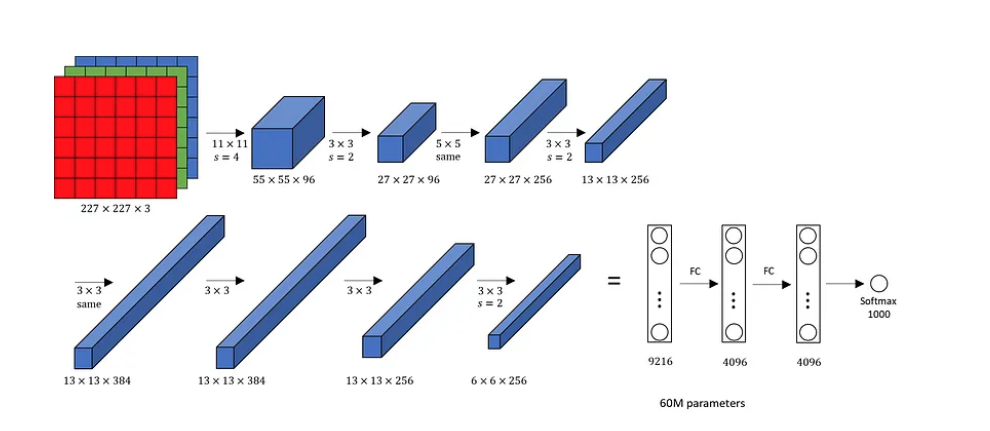

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import numpy as np

# MC Dropout class
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

class AlexNet_MCDropout():
    def __init__(self):
        model = Sequential()

        # First Conv Layer
        model.add(Conv2D(96, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        # Second Conv Layer
        model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        # Third Conv Layer
        model.add(Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'))

        # Fourth Conv Layer
        model.add(Conv2D(384, (3, 3), strides=1, padding='same', activation='relu'))

        # Fifth Conv Layer
        model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        # Flatten
        model.add(Flatten())

        # Fully Connected Layer 1
        model.add(Dense(512, activation='relu'))
        model.add(MCDropout(0.5))

        # Fully Connected Layer 2
        model.add(Dense(512, activation='relu'))
        model.add(MCDropout(0.5))

        # Output Layer
        model.add(Dense(10, activation='softmax'))

        self.model = model

    def fit(self, X_train, y_train, validation_data, epochs, batch_size, verbose):
        self.model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                     validation_data=validation_data, verbose=verbose)
        return self.result

    def predict_with_mc_dropout(self, X_test, y_test, n_simulations=10):
        """
        Monte Carlo Dropout at test time:
        Run the model multiple times with dropout keeps to True. As a result everytime different result will produce and finally produce the output by averaging the predictions over n_simulations, and calculate accuracy.

        Parameters:
            X_test (np.array): Test dataset.
            y_test (np.array): True labels for the test set.
            n_simulations (int): The number of simulations to average over.

        Returns:
            accuracy (float): The accuracy of the predictions.
        """
        predictions = np.zeros((X_test.shape[0], 10))  # 10 classes for CIFAR-10

        # Run MC dropout simulations
        for _ in range(n_simulations):
            pred = self.model(X_test, training=True)  # Keep dropout active during inference
            predictions += pred.numpy()

        # Average the predictions
        predictions /= n_simulations

        # Get the predicted class (the class with the highest probability)
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the true class labels
        true_classes = np.argmax(y_test, axis=1)

        # Calculate accuracy
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

# Monte Carlo Dropout in LeNet architecture

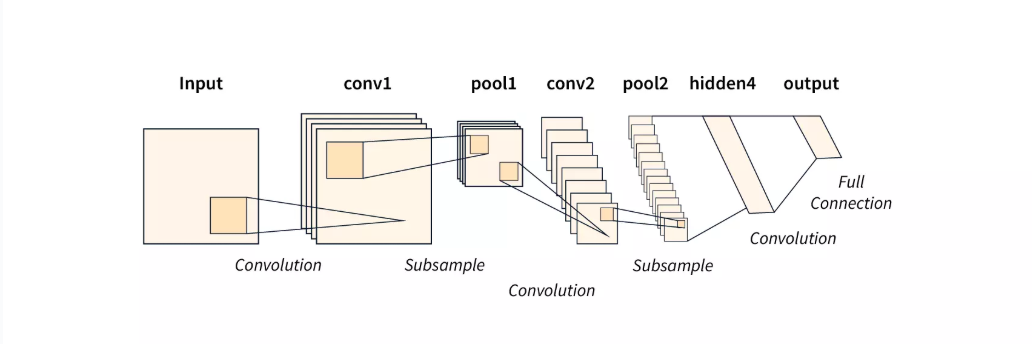

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
import numpy as np

# Custom Dropout for MC Dropout
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        # Dropout is always active during training and inference
        return super().call(inputs, training=True)  # Always apply dropout

class Lenet_MCDropout:
    def __init__(self):
        model = Sequential()
        # Change the input shape to (32, 32, 3) for CIFAR-10
        model.add(Conv2D(30, (10, 10), input_shape=(32, 32, 3), padding='same', activation="relu"))
        model.add(MCDropout(0.5))  # Apply MC Dropout
        model.add(MaxPooling2D((3, 3), strides=2))  # Keep stride 2 but reduce kernel size
        model.add(Conv2D(60, (5, 5), activation="relu", strides=1))
        model.add(MCDropout(0.5))  # Apply MC Dropout
        model.add(MaxPooling2D((2, 2)))  # Use a smaller pool size to preserve dimension
        model.add(Conv2D(90, (3, 3), activation="relu", strides=1))
        model.add(MCDropout(0.5))  # Apply MC Dropout
        model.add(MaxPooling2D((2, 2)))  # Another smaller pool size
        model.add(Flatten())
        model.add(Dense(1000, activation='relu'))
        model.add(MCDropout(0.5))  # Apply MC Dropout
        model.add(Dense(10))
        model.add(Activation('softmax'))
        self.model = model

    def fit(self, X_train, y_train, validation_data, epochs, batch_size, verbose):
        self.model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                     validation_data=validation_data, verbose=verbose)
        return self

    def predict_with_mc_dropout(self, X_test, y_test, n_simulations=10):
        """
        Monte Carlo Dropout at test time:
        Run the model multiple times with dropout, average the predictions, and calculate accuracy.

        Parameters:
            X_test (np.array): Test dataset.
            y_test (np.array): True labels for the test set.
            n_simulations (int): The number of simulations to average over.

        Returns:
            accuracy (float): The accuracy of the predictions.
        """
        predictions = np.zeros((X_test.shape[0], 10))

        for _ in range(n_simulations):
            pred = self.model(X_test, training=True)  #
            predictions += pred.numpy()

        predictions /= n_simulations
        predicted_classes = np.argmax(predictions, axis=1)

        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

# Monte Carlo Dropout on Resnet-50

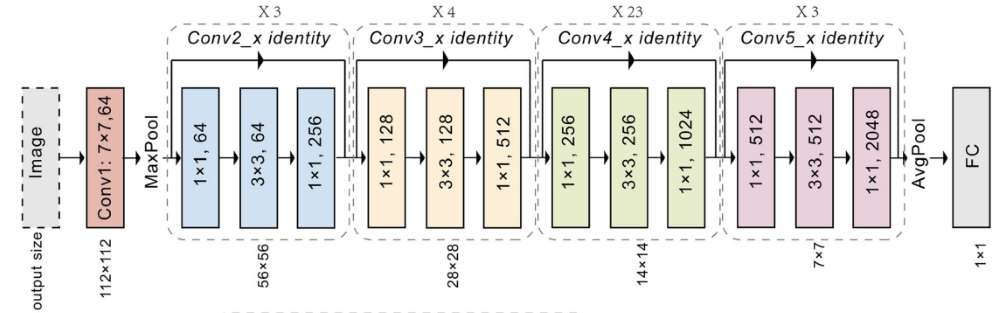

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)  # Always apply dropout

class BasicBlock(tf.keras.layers.Layer):
    expansion = 1

    def __init__(self, filters, stride=1, downsample=None, dropout_rate=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.dropout = MCDropout(dropout_rate)
        self.conv2 = layers.Conv2D(filters, kernel_size=3, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.downsample = downsample

    def call(self, inputs, training=True):
        identity = inputs
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)
        out = self.dropout(out, training=True)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        if self.downsample is not None:
            identity = self.downsample(inputs)

        out += identity
        out = self.relu(out)
        out = self.dropout(out, training=True)
        return out

class Bottleneck(tf.keras.layers.Layer):
    expansion = 4

    def __init__(self, filters, stride=1, downsample=None, dropout_rate=0.3):
        super(Bottleneck, self).__init__()
        width = filters
        self.conv1 = layers.Conv2D(width, kernel_size=1, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(width, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters * self.expansion, kernel_size=1, use_bias=False)
        self.bn3 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.dropout = MCDropout(dropout_rate)
        self.downsample = downsample

    def call(self, inputs, training=True):
        identity = inputs
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)
        out = self.dropout(out, training=True)

        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = self.relu(out)
        out = self.dropout(out, training=True)

        out = self.conv3(out)
        out = self.bn3(out, training=training)

        if self.downsample is not None:
            identity = self.downsample(inputs)

        out += identity
        out = self.relu(out)
        out = self.dropout(out, training=True)
        return out

def make_layer(block, filters, blocks, stride=1, dropout_rate=0.3):
    downsample = None
    if stride != 1 or filters * block.expansion != filters:
        downsample = models.Sequential([
            layers.Conv2D(filters * block.expansion, kernel_size=1, strides=stride, use_bias=False),
            layers.BatchNormalization()
        ])

    layers_list = [block(filters, stride, downsample, dropout_rate=dropout_rate)]
    for _ in range(1, blocks):
        layers_list.append(block(filters, dropout_rate=dropout_rate))

    return models.Sequential(layers_list)

class ResNet50(models.Model):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(ResNet50, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = make_layer(Bottleneck, 64, 3, dropout_rate=dropout_rate)
        self.layer2 = make_layer(Bottleneck, 128, 4, stride=2, dropout_rate=dropout_rate)
        self.layer3 = make_layer(Bottleneck, 256, 6, stride=2, dropout_rate=dropout_rate)
        self.layer4 = make_layer(Bottleneck, 512, 3, stride=2, dropout_rate=dropout_rate)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes)
        self.dropout = MCDropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.avgpool(x)
        x = self.dropout(x, training=True)
        x = self.fc(x)
        return x

class ResNet50_MCDropout:
    def __init__(self, num_classes=10, dropout_rate=0.3):
        self.model = ResNet50(num_classes=num_classes, dropout_rate=dropout_rate)

    def fit(self, X_train, y_train, validation_data, epochs, batch_size, verbose):
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                     validation_data=validation_data, verbose=verbose)
        return self

    def predict_with_mc_dropout(self, X_test, y_test, n_simulations=10):
        """
        Monte Carlo Dropout at test time:
        Run the model multiple times with dropout, average the predictions, and calculate accuracy.

        Parameters:
            X_test (np.array): Test dataset.
            y_test (np.array): True labels for the test set.
            n_simulations (int): The number of simulations to average over.

        Returns:
            accuracy (float): The accuracy of the predictions.
        """
        predictions = np.zeros((X_test.shape[0], 10))

        for _ in range(n_simulations):
            pred = self.model(X_test, training=True)  #
            predictions += pred.numpy()

        predictions /= n_simulations
        predicted_classes = np.argmax(predictions, axis=1)

        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

# Train Epoch

In [7]:
def train_model(model, X_train, y_train, validation_data, lr=0.01, epochs=100, batch_size=64):
    """
    Function to train the Keras model.

    Parameters:
    - model: The Keras model to train.
    - X_train: Training data (numpy array).
    - y_train: Training labels (numpy array).
    - validation_data: Tuple of validation data (X_valid, y_valid).
    - lr: Learning rate for the optimizer (default: 0.01).
    - epochs: Number of epochs to train the model (default: 10).
    - batch_size: Batch size for training (default: 32).

    Returns:
    - history: The training history object, which contains loss and accuracy for each epoch.
    """

    # Compile the model
    model.model.compile(optimizer=SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=validation_data, verbose=1)

    return history

# Plot loss, accuracy over the epochs

In [6]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """
    Plots training and validation loss and accuracy from the history object.

    Parameters:
    history: Keras History object containing training history.
    """
    train_loss = history.history['loss']
    valid_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    valid_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def get_model(model_name):
    """
    Returns the specified model based on the model name.

    Parameters:
    model_name (str): Name of the model to retrieve.

    Returns:
    model: The corresponding model instance.
    """
    if model_name == 'resnet50':
        return ResNet50_MCDropout()
    elif model_name == 'alexnet':
        return AlexNet_MCDropout()
    elif model_name == 'lenet':
        return Lenet_MCDropout()
    else:
        raise ValueError(f"Model {model_name} not recognized")

In [ ]:
trainset, testset, inputs, num_classes = getDataset('CIFAR10')
train_loader, valid_loader, test_loader = getDataloader(trainset, testset, valid_size=0.2, batch_size=64, num_workers=4)
X_train, y_train = convert_to_numpy(train_loader)
X_valid, y_valid = convert_to_numpy(valid_loader)
X_test, y_test = convert_to_numpy(test_loader)
#Give you model name - > alexnet, lenet, resnet50
model_name = 'alexnet'
model = get_model(model_name)


# Train the model
history = train_model(model, X_train, y_train, (X_valid, y_valid), lr=0.01, epochs=5, batch_size=64)

train_loss = history.history['loss']
valid_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

print(f"Training Loss: {train_loss[-1]}, Validation Loss: {valid_loss[-1]}")
print(f"Training Accuracy: {train_accuracy[-1]}, Validation Accuracy: {valid_accuracy[-1]}")
plot_training_metrics(history)

# Inference

In [ ]:
# Example of Monte Carlo inference
n_iter = 20  # Number of Monte Carlo simulations
accuracy = model.predict_with_mc_dropout(X_test,y_test, n_simulations=n_iter)
print(accuracy)